##Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
Copy Datasets
"C:\Users\thakc\OneDrive\รูปภาพ\archive.zip"

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3769505302.py, line 1)

In [ ]:
 !unzip 'C:\Users\ComGu\Desktop\Lab5\archive.zip' -d '/content/'

In [1]:
!pip install "tensorflow==2.16.1"


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# Augment 2 ทาง: ./augmented/<class> และ ./augmented-CY/<class>/<transform>
from pathlib import Path
from PIL import Image, ImageOps
import math

# ====== CONFIG ======
INPUT_ROOT = Path("./Datasets")

# ปลายทางสองแบบตามที่ร้องขอ
OUTPUT_ROOT_FLAT = Path("./augmented")      # แบบรวมตามคลาส
OUTPUT_ROOT_BY_TRANSFORM = Path("./augmented-CY")  # แบบแยกตามชนิดการปรับ

CLASSES = [
    "cloudy", "foggy", "rainy", "snowy", "sunny",
]

# เฉพาะ 4 การปรับ
ROTATE_ANGLES = [45]     # องศา
DO_HFLIP = True          # กลับซ้ายขวา
SHEAR_X_DEG = [20]       # shear แนวนอน (องศา)
ZOOM_FACTORS = [1.20]    # >1 = ซูมเข้า
# =====================

FILL_COLOR = (0, 0, 0)
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

# ====== Helpers ======
def load_rgb(path: Path) -> Image.Image:
    img = Image.open(path)
    if img.mode != "RGB":
        img = img.convert("RGB")
    return img

def _ensure_unique(out_path: Path) -> Path:
    if not out_path.exists():
        return out_path
    stem, ext = out_path.stem, out_path.suffix
    i = 1
    while True:
        cand = out_path.with_name(f"{stem}_{i}{ext}")
        if not cand.exists():
            return cand
        i += 1

def save_both(img: Image.Image, cls: str, transform_folder: str, base_stem: str, suffix: str):
    # 1) แบบรวมตามคลาส: ./augmented/<class>/<basename>_<suffix>.jpeg
    flat_dir = OUTPUT_ROOT_FLAT / cls
    flat_dir.mkdir(parents=True, exist_ok=True)
    p1 = _ensure_unique(flat_dir / f"{base_stem}_{suffix}.jpeg")
    img.save(p1, "JPEG", quality=95)

    # 2) แบบแยกตามชนิด: ./augmented-CY/<class>/<transform>/<basename>_<suffix>.jpeg
    tf_dir = OUTPUT_ROOT_BY_TRANSFORM / cls / transform_folder
    tf_dir.mkdir(parents=True, exist_ok=True)
    p2 = _ensure_unique(tf_dir / f"{base_stem}_{suffix}.jpeg")
    img.save(p2, "JPEG", quality=95)

def rotate_fit(img: Image.Image, angle: float) -> Image.Image:
    w, h = img.size
    r = img.rotate(angle, resample=Image.BICUBIC, expand=True, fillcolor=FILL_COLOR)
    rw, rh = r.size
    left = max((rw - w) // 2, 0)
    top  = max((rh - h) // 2, 0)
    return r.crop((left, top, left + w, top + h))

def shear_x(img: Image.Image, deg: float) -> Image.Image:
    m = math.tan(math.radians(deg))
    return img.transform(img.size, Image.AFFINE, (1, m, 0, 0, 1, 0),
                         resample=Image.BICUBIC, fillcolor=FILL_COLOR)

def zoom_center_crop(img: Image.Image, factor: float) -> Image.Image:
    w, h = img.size
    nw, nh = int(round(w * factor)), int(round(h * factor))
    z = img.resize((nw, nh), Image.BICUBIC)
    left = (nw - w) // 2
    top  = (nh - h) // 2
    return z.crop((left, top, left + w, top + h))

def augment_one(path: Path, cls: str):
    img = load_rgb(path)
    stem = path.stem

    # 1) rotation-45
    for ang in ROTATE_ANGLES:
        out = rotate_fit(img, ang)
        save_both(out, cls, f"rotation-{int(ang)}", stem, f"rot{int(ang)}")

    # 2) flip-horizontal
    if DO_HFLIP:
        out = ImageOps.mirror(img)
        save_both(out, cls, "flip-horizontal", stem, "hflip")

    # 3) shearx-20deg
    for deg in SHEAR_X_DEG:
        out = shear_x(img, deg)
        save_both(out, cls, f"shearx-{int(deg)}deg", stem, f"shx{int(deg)}")

    # 4) zoom-120pct
    for f in ZOOM_FACTORS:
        tag = f"{int(round(f*100))}pct"
        out = zoom_center_crop(img, f)
        save_both(out, cls, f"zoom-{tag}", stem, f"zm{tag}")

# ====== RUN ======
OUTPUT_ROOT_FLAT.mkdir(parents=True, exist_ok=True)
OUTPUT_ROOT_BY_TRANSFORM.mkdir(parents=True, exist_ok=True)

for cls in CLASSES:
    in_dir = INPUT_ROOT / cls
    if not in_dir.exists():
        print(f"[!] ข้าม {cls} (ไม่พบ {in_dir})")
        continue
    print(f"- ทำคลาส: {cls}")
    files = [p for p in in_dir.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS]
    if not files:
        print(f"  ไม่มีไฟล์รูปใน {in_dir}, ข้าม")
        continue
    for p in files:
        augment_one(p, cls)

print("\n✅ เสร็จสิ้น")
print("  แบบรวมตามคลาส:      ", OUTPUT_ROOT_FLAT.resolve(), "/<class>")
print("  แบบแยกตามชนิดการปรับ:", OUTPUT_ROOT_BY_TRANSFORM.resolve(), "/<class>/<transform>")


- ทำคลาส: cloudy


C:\Users\thakc\AppData\Local\Temp\ipykernel_10156\30917106.py:60: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  r = img.rotate(angle, resample=Image.BICUBIC, expand=True, fillcolor=FILL_COLOR)
C:\Users\thakc\AppData\Local\Temp\ipykernel_10156\30917106.py:68: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
  return img.transform(img.size, Image.AFFINE, (1, m, 0, 0, 1, 0),
C:\Users\thakc\AppData\Local\Temp\ipykernel_10156\30917106.py:69: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resample=Image.BICUBIC, fillcolor=FILL_COLOR)
C:\Users\thakc\AppData\Local\Temp\ipykernel_10156\30917106.py:74: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  z = img.resize((nw, nh), Image.BICUBIC)


- ทำคลาส: foggy
- ทำคลาส: rainy
- ทำคลาส: snowy
- ทำคลาส: sunny

✅ เสร็จสิ้น
  แบบรวมตามคลาส:       C:\Users\thakc\OneDrive\Desktop\dataset\augmented /<class>
  แบบแยกตามชนิดการปรับ: C:\Users\thakc\OneDrive\Desktop\dataset\augmented-CY /<class>/<transform>


In [6]:
# Count files per class in ./augmented/<class>
import os
from pathlib import Path

BASE_DIR = Path("./augmented")
CLASSES = [
    "cloudy", "foggy", "rainy", "snowy", "sunny",
]
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}

def count_images(folder: Path) -> int:
    if not folder.exists():
        print(f"[!] ไม่พบโฟลเดอร์: {folder}")
        return 0
    return sum(1 for p in folder.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS)

total = 0
for cls in CLASSES:
    dir_path = BASE_DIR / cls
    n = count_images(dir_path)
    total += n
    print(f"Number of files in {dir_path}: {n}")

print(f"\nTOTAL images across classes: {total}")


Number of files in augmented\cloudy: 26808
Number of files in augmented\foggy: 5040
Number of files in augmented\rainy: 7708
Number of files in augmented\snowy: 7500
Number of files in augmented\sunny: 25096

TOTAL images across classes: 72152


In [7]:
# Calculate 20% validation count per class from ./augmented/<class>
from pathlib import Path

BASE_DIR = Path("./augmented")
CLASSES = [
   "cloudy", "foggy", "rainy", "snowy", "sunny",
]
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}

def count_images(folder: Path) -> int:
    if not folder.exists():
        print(f"[!] ไม่พบโฟลเดอร์: {folder}")
        return 0
    return sum(1 for p in folder.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS)

# นับจำนวนรูปต่อคลาส
counts = {cls: count_images(BASE_DIR / cls) for cls in CLASSES}

# คำนวณ 20% สำหรับ validation (ปัดด้วย round แบบเดิม)
VAL_RATIO = 0.2
val_counts = {cls: round(counts[cls] * VAL_RATIO) for cls in CLASSES}

# แสดงผล
for cls in CLASSES:
    print(f"Validate for {cls}: {val_counts[cls]}")

print(f"\nTOTAL images: {sum(counts.values())}")
print(f"TOTAL validate (20%): {sum(val_counts.values())}")


Validate for cloudy: 5362
Validate for foggy: 1008
Validate for rainy: 1542
Validate for snowy: 1500
Validate for sunny: 5019

TOTAL images: 72152
TOTAL validate (20%): 14431


In [8]:
import os
import random
import shutil
from pathlib import Path

# ต้นทางและปลายทาง
source_dir = Path("./augmented")
test_dir = Path("./test_augmented")

# สัดส่วนที่จะย้ายไป test
val_ratio = 0.2

# รายชื่อคลาสตามโฟลเดอร์ในภาพ
CLASSES = [
    "cloudy", "foggy", "rainy", "snowy", "sunny",
]

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}

# สุ่มแบบทำซ้ำได้
random.seed(42)

# สร้างโฟลเดอร์ปลายทางแต่ละคลาส
for cls in CLASSES:
    (test_dir / cls).mkdir(parents=True, exist_ok=True)

def list_images(folder: Path):
    return [f.name for f in folder.iterdir()
            if f.is_file() and f.suffix.lower() in IMG_EXTS]

def move_with_collision(src: Path, dst: Path):
    """ย้ายไฟล์ ถ้าชื่อซ้ำจะเติม _1, _2, ... ที่ปลายทาง"""
    target = dst
    if target.exists():
        stem, ext = target.stem, target.suffix
        i = 1
        while True:
            candidate = target.with_name(f"{stem}_{i}{ext}")
            if not candidate.exists():
                target = candidate
                break
            i += 1
    shutil.move(str(src), str(target))

total_moved = 0

for cls in CLASSES:
    src_cls = source_dir / cls
    dst_cls = test_dir / cls

    if not src_cls.exists():
        print(f"[!] ข้าม {cls} (ไม่พบ: {src_cls})")
        continue

    files = list_images(src_cls)
    n_to_move = min(round(len(files) * val_ratio), len(files))

    if n_to_move == 0:
        print(f"{cls}: ไม่มีไฟล์ให้ย้าย")
        continue

    chosen = random.sample(files, k=n_to_move)
    for name in chosen:
        move_with_collision(src_cls / name, dst_cls / name)

    total_moved += n_to_move
    print(f"{cls}: moved {n_to_move} / {len(files)} images -> {dst_cls}")

print(f"\n✅ Done. Total moved: {total_moved}")
print(f"From: {source_dir.resolve()}\nTo:   {test_dir.resolve()}")


cloudy: moved 5362 / 26808 images -> test_augmented\cloudy
foggy: moved 1008 / 5040 images -> test_augmented\foggy
rainy: moved 1542 / 7708 images -> test_augmented\rainy
snowy: moved 1500 / 7500 images -> test_augmented\snowy
sunny: moved 5019 / 25096 images -> test_augmented\sunny

✅ Done. Total moved: 14431
From: C:\Users\thakc\OneDrive\Desktop\dataset\augmented
To:   C:\Users\thakc\OneDrive\Desktop\dataset\test_augmented


In [9]:
# Count data per class in ./augmented/<class>
import os
from pathlib import Path

BASE_DIR = Path("./augmented")
CLASSES = [
    "cloudy", "foggy", "rainy", "snowy", "sunny",
]
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def count_images(folder: Path) -> int:
    if not folder.exists():
        print(f"[!] ไม่พบโฟลเดอร์: {folder}")
        return 0
    return sum(1 for p in folder.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS)

counts = {cls: count_images(BASE_DIR / cls) for cls in CLASSES}

for cls in CLASSES:
    print(f"Number of files in {BASE_DIR/cls}: {counts[cls]}")

print(f"\nTOTAL images across classes: {sum(counts.values())}")


Number of files in augmented\cloudy: 21446
Number of files in augmented\foggy: 4032
Number of files in augmented\rainy: 6166
Number of files in augmented\snowy: 6000
Number of files in augmented\sunny: 20077

TOTAL images across classes: 57721


In [10]:
# Count data in ./test_augmented/<class> ทำถึงนี่พอ
import os
from pathlib import Path

BASE_DIR = Path("./test_augmented")
CLASSES = [
    "cloudy", "foggy", "rainy", "snowy", "sunny",
]
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def count_images(folder: Path) -> int:
    if not folder.exists():
        print(f"[!] ไม่พบโฟลเดอร์: {folder}")
        return 0
    return sum(1 for p in folder.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS)

counts = {cls: count_images(BASE_DIR / cls) for cls in CLASSES}

for cls in CLASSES:
    print(f"Number of files in {BASE_DIR/cls}: {counts[cls]}")

print(f"\nTOTAL images across classes: {sum(counts.values())}")


Number of files in test_augmented\cloudy: 5362
Number of files in test_augmented\foggy: 1008
Number of files in test_augmented\rainy: 1542
Number of files in test_augmented\snowy: 1500
Number of files in test_augmented\sunny: 5019

TOTAL images across classes: 14431


#Install Timm

In [12]:
# Install Timm (Need to restart the runtime after finish install )
# !pip install git+https://github.com/rwightman/pytorch-image-models.git
# !pip install lightning transformers datasets evaluate pillow
# !pip install --upgrade Pillow
# !pip install --upgrade torchvision

In [15]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split, Dataset


# Pytorch Image model (TIMM) library: a library for state-of-the-art image classification
import timm
import timm.optim
import timm.scheduler
from timm.data import ImageDataset, create_dataset, create_loader
from timm.data.transforms_factory import create_transform

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from PIL import Image

import evaluate

import numpy as np
import pandas as pd
from scipy import stats

from tqdm.notebook import tqdm

import glob

from sklearn.model_selection import StratifiedKFold,KFold

from lightning.fabric import Fabric

from copy import copy

import shutil

from sklearn.utils.class_weight import compute_class_weight

##visualization Model

In [16]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")

In [17]:
# Select model (List of available is shown above)
import timm
from torchinfo import summary

# Define model names (paths)
mobilenetv3_large_100 = "hf_hub:timm/mobilenetv3_large_100.miil_in21k_ft_in1k"
efficientnet_b0 = "hf_hub:timm/efficientnet_b0.ra_in1k"
resnet50 = "hf_hub:timm/resnet50.a1_in1k"
vit_base_patch16_224 = "vit_base_patch16_224_in21k"
densenet201 = "densenet201"

num_classes = 8

# สร้างโมเดลก่อน

mobilenetv3_large_100_model = timm.create_model('mobilenetv3_large_100', pretrained=True, num_classes=num_classes)
efficientnet_model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)
resnet_model = timm.create_model('resnet50', pretrained=True, num_classes=num_classes)
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
densenet_model = timm.create_model('densenet201', pretrained=True, num_classes=num_classes)

# เก็บโมเดลทั้งหมดใน dictionary
models = {
    "mobilenetv3": mobilenetv3_large_100_model,
    "efficientnet": efficientnet_model,
    "resnet": resnet_model,
    "vit": vit_model, # This model is causing an error
    "densenet": densenet_model # This model is causing an error
}

# แสดง summary ของแต่ละโมเดล
for name, model in models.items():
    print(f"Summary for {name}:")
    summary(model=model, input_size=(16, 3, 224, 224),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20, row_settings=["var_names"])
    print()

model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

c:\Users\puppa\gpu_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\puppa\.cache\huggingface\hub\models--timm--mobilenetv3_large_100.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/81.1M [00:00<?, ?B/s]

c:\Users\puppa\gpu_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\puppa\.cache\huggingface\hub\models--timm--densenet201.tv_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Summary for mobilenetv3:

Summary for efficientnet:

Summary for resnet:

Summary for vit:

Summary for densenet:



In [18]:
# Transform image data based on ImageNet's mean and std
transforms = {
    "train": T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ]),
    "test": T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ])
}

In [19]:
train_dir = r'./augmented'

In [20]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
dataset = datasets.ImageFolder(root=train_dir , # target folder of images
                                  transform=transforms["train"], # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

In [21]:
dataset.class_to_idx

{'battery': 0,
 'biological': 1,
 'brown-glass': 2,
 'cardboard': 3,
 'clothes': 4,
 'green-glass': 5,
 'metal': 6,
 'paper': 7,
 'plastic': 8,
 'shoes': 9,
 'trash': 10,
 'white-glass': 11}

In [22]:
len(dataset)

39722

In [23]:
# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
Select Model
model_name = "hf_hub:timm/mobilenetv3_large_100.miil_in21k_ft_in1k"

In [10]:
num_epochs = 5
criterion = nn.CrossEntropyLoss()

# Cross Validation Configuration
k_splits = 5
metric = evaluate.load("accuracy")

In [11]:
# Cross validation
kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)

In [12]:
# Gradient Accumulation Settings
# Set to 1 for no accumulation
train_batch_size = 16
eval_batch_size = 8
num_accumulate = 1

In [13]:
torch.set_float32_matmul_precision('high')
fabric = Fabric(accelerator="cpu", precision="bf16-mixed")
fabric.launch()

Using bfloat16 Automatic Mixed Precision (AMP)


In [32]:
# import torch
# print(torch.__version__)
# print(torch.cuda.is_available())


In [36]:
import time

In [ ]:
 import timm
import torch
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
from lightning.fabric import Fabric

# Initialize Fabric with GPU configuration
fabric = Fabric(accelerator="cpu", devices=1)  # Use 1 GPU, change devices for multi-GPU
fabric.launch()

# Set device for manual operations
device = fabric.device
print(f"Using device: {device}")

all_eval_scores = {}
model_names = [
    "mobilenetv3_large_100",
    "efficientnet_b0",
    "resnet50",
    "vit_base_patch16_224", # This model is causing an error
    "densenet121" # This model is causing an error
]

for model_name in model_names:
    print(f"Training model: {model_name}")
    model_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"Fold {fold+1} of {k_splits} for model {model_name}")

        # Load Model and move to GPU via fabric
        model = timm.create_model(model_name, pretrained=True, num_classes=8)

        # Optimizer and Scheduler
        optimizer = timm.optim.create_optimizer_v2(model, opt="AdamW", lr=5e-4)
        model, optimizer = fabric.setup(model, optimizer)
        scheduler = timm.scheduler.create_scheduler_v2(optimizer, num_epochs=num_epochs)[0]

        # Data Loaders
        train_dataset = torch.utils.data.Subset(dataset, train_idx)
        val_dataset = torch.utils.data.Subset(dataset, val_idx)
        train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=4, pin_memory=True)
        val_dataloader = DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=4, pin_memory=True)
        train_dataloader, val_dataloader = fabric.setup_dataloaders(train_dataloader, val_dataloader)

        info = {
            "metric_train": [],
            "metric_val": [],
            "train_loss": [],
            "val_loss": [],
            "best_metric_val": -999,
            "best_val_loss": 999,
        }

        for epoch in range(num_epochs):
            train_loss_epoch = []
            val_loss_epoch = []

            train_preds = []
            train_targets = []

            val_preds = []
            val_targets = []

            num_updates = epoch * len(train_dataloader)

            # Train
            s1 = time.time()
            model.train()
            for idx, batch in enumerate(tqdm(train_dataloader)):
                inputs, targets = batch
                # Data is automatically moved to GPU by fabric.setup_dataloaders
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                fabric.backward(loss)

                if ((idx + 1) % num_accumulate == 0) or (idx + 1 == len(train_dataloader)):
                    optimizer.step()
                    scheduler.step_update(num_updates=num_updates)
                    optimizer.zero_grad()

                train_loss_epoch.append(loss.item())
                train_preds += outputs.argmax(-1).detach().cpu().tolist()
                train_targets += targets.detach().cpu().tolist()  # Move targets to CPU for metrics

            scheduler.step(epoch + 1)

            # Validation
            model.eval()
            with torch.no_grad():
                for batch in tqdm(val_dataloader):
                    inputs, targets = batch
                    # Data is automatically moved to GPU by fabric.setup_dataloaders
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    val_loss_epoch.append(loss.item())
                    val_preds += outputs.argmax(-1).detach().cpu().tolist()
                    val_targets += targets.detach().cpu().tolist()  # Move targets to CPU for metrics

            s2 = time.time()
            elapsed_time = s2 - s1

            metric_train = metric.compute(predictions=train_preds, references=train_targets)["accuracy"]
            metric_val = metric.compute(predictions=val_preds, references=val_targets)["accuracy"]

            info["metric_train"].append(metric_train)
            info["metric_val"].append(metric_val)
            info["train_loss"].append(np.average(train_loss_epoch))
            info["val_loss"].append(np.average(val_loss_epoch))

            if metric_val > info["best_metric_val"]:
                print("New Best Score!")
                info["best_metric_val"] = metric_val
                # Save model state dict to avoid fabric wrapper issues
                torch.save(model.state_dict(), f"{model_name}_checkpoint_fold{fold}.pt")

            print(f"Fold: {fold} | Epoch: {epoch} | Time: {elapsed_time:.2f} sec")
            print(f"Train Acc: {metric_train:.4f} | Val Acc: {metric_val:.4f} | Train Loss: {np.average(train_loss_epoch):.4f} | Val Loss: {np.average(val_loss_epoch):.4f}")

        model_scores.append(info["best_metric_val"])

    all_eval_scores[model_name] = model_scores

print("All evaluation scores per model and fold:")
print(all_eval_scores)

Using device: cpu
Training model: mobilenetv3_large_100
Fold 1 of 5 for model mobilenetv3_large_100


  0%|          | 0/528 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [38]:
classname = dataset.classes
classname

['fan_a',
 'fan_n',
 'pump_a',
 'pump_n',
 'slider_a',
 'slider_n',
 'valve_a',
 'valve_n']

  0%|          | 0/72 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 72/72 [00:54<00:00,  1.31it/s]


Fold: 0


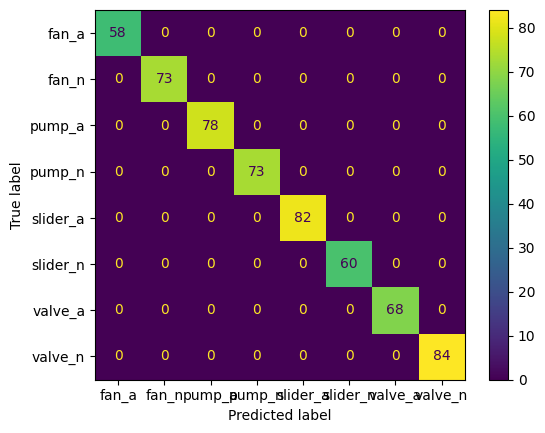

              precision    recall  f1-score   support

       fan_a       1.00      1.00      1.00        58
       fan_n       1.00      1.00      1.00        73
      pump_a       1.00      1.00      1.00        78
      pump_n       1.00      1.00      1.00        73
    slider_a       1.00      1.00      1.00        82
    slider_n       1.00      1.00      1.00        60
     valve_a       1.00      1.00      1.00        68
     valve_n       1.00      1.00      1.00        84

    accuracy                           1.00       576
   macro avg       1.00      1.00      1.00       576
weighted avg       1.00      1.00      1.00       576



  0%|          | 0/72 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 72/72 [00:55<00:00,  1.31it/s]


Fold: 1


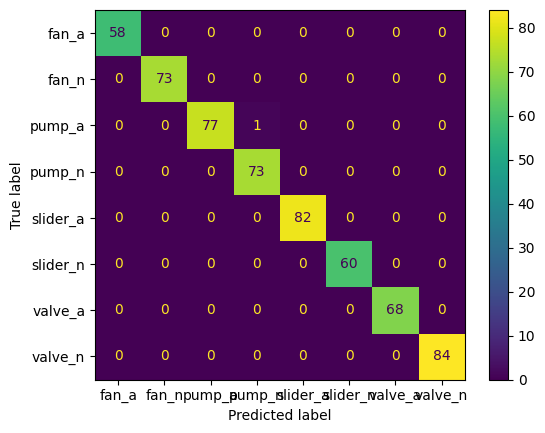

              precision    recall  f1-score   support

       fan_a       1.00      1.00      1.00        58
       fan_n       1.00      1.00      1.00        73
      pump_a       1.00      0.99      0.99        78
      pump_n       0.99      1.00      0.99        73
    slider_a       1.00      1.00      1.00        82
    slider_n       1.00      1.00      1.00        60
     valve_a       1.00      1.00      1.00        68
     valve_n       1.00      1.00      1.00        84

    accuracy                           1.00       576
   macro avg       1.00      1.00      1.00       576
weighted avg       1.00      1.00      1.00       576



  0%|          | 0/72 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 72/72 [01:05<00:00,  1.09it/s]


Fold: 2


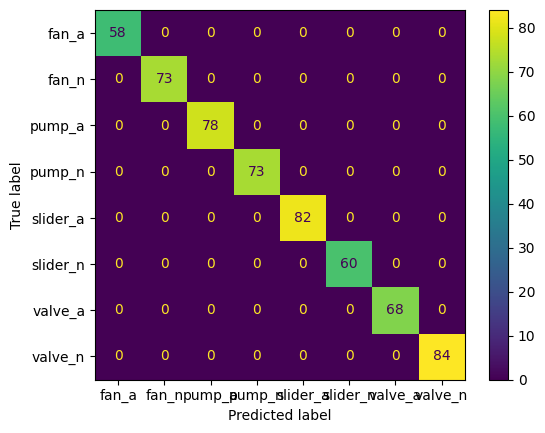

              precision    recall  f1-score   support

       fan_a       1.00      1.00      1.00        58
       fan_n       1.00      1.00      1.00        73
      pump_a       1.00      1.00      1.00        78
      pump_n       1.00      1.00      1.00        73
    slider_a       1.00      1.00      1.00        82
    slider_n       1.00      1.00      1.00        60
     valve_a       1.00      1.00      1.00        68
     valve_n       1.00      1.00      1.00        84

    accuracy                           1.00       576
   macro avg       1.00      1.00      1.00       576
weighted avg       1.00      1.00      1.00       576



  0%|          | 0/72 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 72/72 [00:54<00:00,  1.32it/s]


Fold: 3


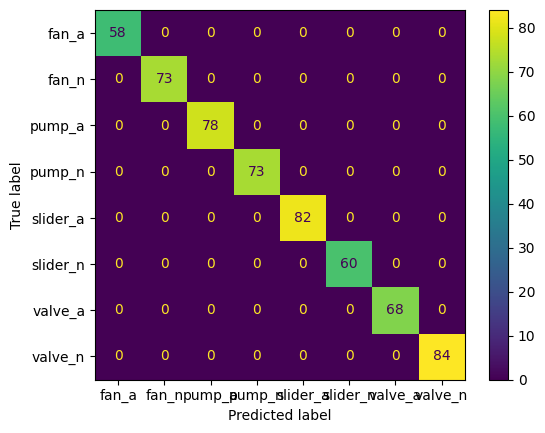

              precision    recall  f1-score   support

       fan_a       1.00      1.00      1.00        58
       fan_n       1.00      1.00      1.00        73
      pump_a       1.00      1.00      1.00        78
      pump_n       1.00      1.00      1.00        73
    slider_a       1.00      1.00      1.00        82
    slider_n       1.00      1.00      1.00        60
     valve_a       1.00      1.00      1.00        68
     valve_n       1.00      1.00      1.00        84

    accuracy                           1.00       576
   macro avg       1.00      1.00      1.00       576
weighted avg       1.00      1.00      1.00       576



  0%|          | 0/72 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 72/72 [00:53<00:00,  1.33it/s]


Fold: 4


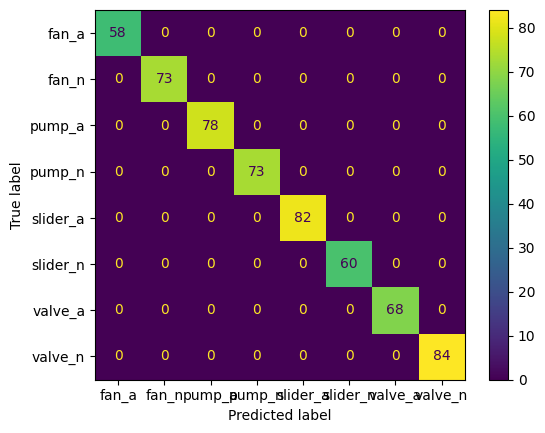

              precision    recall  f1-score   support

       fan_a       1.00      1.00      1.00        58
       fan_n       1.00      1.00      1.00        73
      pump_a       1.00      1.00      1.00        78
      pump_n       1.00      1.00      1.00        73
    slider_a       1.00      1.00      1.00        82
    slider_n       1.00      1.00      1.00        60
     valve_a       1.00      1.00      1.00        68
     valve_n       1.00      1.00      1.00        84

    accuracy                           1.00       576
   macro avg       1.00      1.00      1.00       576
weighted avg       1.00      1.00      1.00       576



In [56]:
import timm
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm

for fold in range(k_splits):
    predictions = []
    references = []

    # สร้างโมเดลใหม่ และโหลด weights
    loaded_model = timm.create_model("densenet121", pretrained=False, num_classes=8)

    loaded_model.load_state_dict(torch.load(f"densenet121_checkpoint_fold{fold}.pt"))
    loaded_model.to(device)
    loaded_model.eval()

    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            inputs, targets = batch
            outputs = loaded_model(inputs.to(device))

            predictions += outputs.argmax(-1).detach().cpu().tolist()
            references += targets.detach().cpu().tolist()

    print(f"Fold: {fold}")

    # Confusion Matrix
    cm = confusion_matrix(references, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classname)
    disp.plot()
    plt.show()

    # Classification Report
    print(classification_report(references, predictions, target_names=classname))


In [40]:
classname = dataset.classes
classname

['fan_a',
 'fan_n',
 'pump_a',
 'pump_n',
 'slider_a',
 'slider_n',
 'valve_a',
 'valve_n']

###Verification by sepreate data

In [43]:
test_folder = r'./test_augmented'

In [44]:
# Making Dataset
from torchvision import datasets
test_dataset = datasets.ImageFolder(root=test_folder, # target folder of images
                                  transform=transforms["test"], # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

In [45]:
len(test_dataset)

720

In [46]:
# Making test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [47]:
test_dataset.classes

['fan_a',
 'fan_n',
 'pump_a',
 'pump_n',
 'slider_a',
 'slider_n',
 'valve_a',
 'valve_n']

In [48]:
len(test_dataloader)

90

  0%|          | 0/90 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 90/90 [00:46<00:00,  1.92it/s]


Fold: 0


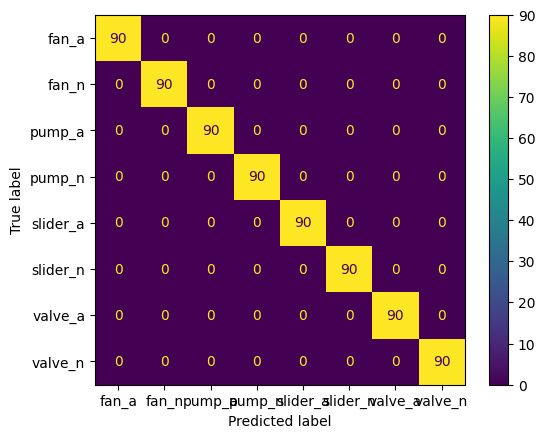

              precision    recall  f1-score   support

       fan_a       1.00      1.00      1.00        90
       fan_n       1.00      1.00      1.00        90
      pump_a       1.00      1.00      1.00        90
      pump_n       1.00      1.00      1.00        90
    slider_a       1.00      1.00      1.00        90
    slider_n       1.00      1.00      1.00        90
     valve_a       1.00      1.00      1.00        90
     valve_n       1.00      1.00      1.00        90

    accuracy                           1.00       720
   macro avg       1.00      1.00      1.00       720
weighted avg       1.00      1.00      1.00       720



  0%|          | 0/90 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 90/90 [00:47<00:00,  1.91it/s]


Fold: 1


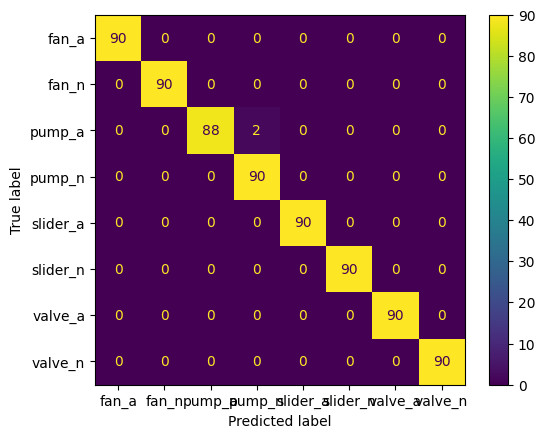

              precision    recall  f1-score   support

       fan_a       1.00      1.00      1.00        90
       fan_n       1.00      1.00      1.00        90
      pump_a       1.00      0.98      0.99        90
      pump_n       0.98      1.00      0.99        90
    slider_a       1.00      1.00      1.00        90
    slider_n       1.00      1.00      1.00        90
     valve_a       1.00      1.00      1.00        90
     valve_n       1.00      1.00      1.00        90

    accuracy                           1.00       720
   macro avg       1.00      1.00      1.00       720
weighted avg       1.00      1.00      1.00       720



  0%|          | 0/90 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 90/90 [00:43<00:00,  2.07it/s]


Fold: 2


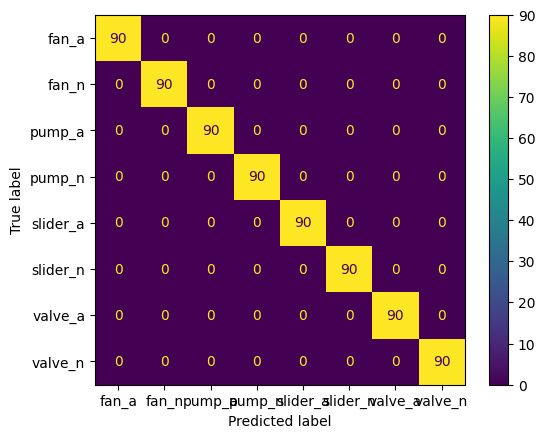

              precision    recall  f1-score   support

       fan_a       1.00      1.00      1.00        90
       fan_n       1.00      1.00      1.00        90
      pump_a       1.00      1.00      1.00        90
      pump_n       1.00      1.00      1.00        90
    slider_a       1.00      1.00      1.00        90
    slider_n       1.00      1.00      1.00        90
     valve_a       1.00      1.00      1.00        90
     valve_n       1.00      1.00      1.00        90

    accuracy                           1.00       720
   macro avg       1.00      1.00      1.00       720
weighted avg       1.00      1.00      1.00       720



  0%|          | 0/90 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 90/90 [00:43<00:00,  2.06it/s]


Fold: 3


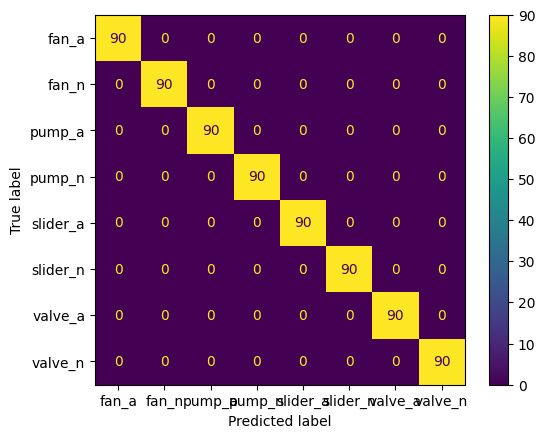

              precision    recall  f1-score   support

       fan_a       1.00      1.00      1.00        90
       fan_n       1.00      1.00      1.00        90
      pump_a       1.00      1.00      1.00        90
      pump_n       1.00      1.00      1.00        90
    slider_a       1.00      1.00      1.00        90
    slider_n       1.00      1.00      1.00        90
     valve_a       1.00      1.00      1.00        90
     valve_n       1.00      1.00      1.00        90

    accuracy                           1.00       720
   macro avg       1.00      1.00      1.00       720
weighted avg       1.00      1.00      1.00       720



  0%|          | 0/90 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 90/90 [00:43<00:00,  2.07it/s]


Fold: 4


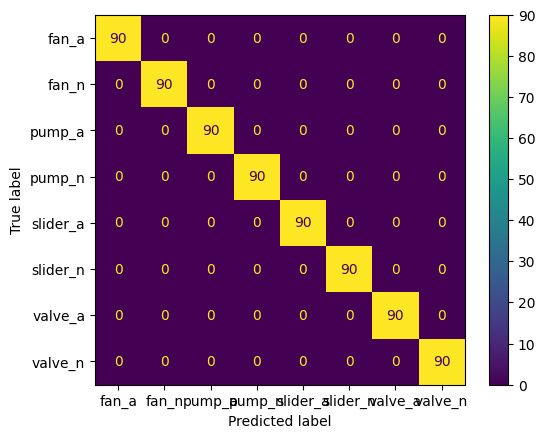

              precision    recall  f1-score   support

       fan_a       1.00      1.00      1.00        90
       fan_n       1.00      1.00      1.00        90
      pump_a       1.00      1.00      1.00        90
      pump_n       1.00      1.00      1.00        90
    slider_a       1.00      1.00      1.00        90
    slider_n       1.00      1.00      1.00        90
     valve_a       1.00      1.00      1.00        90
     valve_n       1.00      1.00      1.00        90

    accuracy                           1.00       720
   macro avg       1.00      1.00      1.00       720
weighted avg       1.00      1.00      1.00       720



In [74]:
import timm
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm

for fold in range(k_splits):
    predictions = []
    references = []

    # สร้างโมเดลใหม่ และโหลด weights
    loaded_model = timm.create_model("densenet121", pretrained=False, num_classes=8)

    loaded_model.load_state_dict(torch.load(f"densenet121_checkpoint_fold{fold}.pt"))
    loaded_model.to(device)
    loaded_model.eval()

    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            inputs, targets = batch
            outputs = loaded_model(inputs.to(device))

            predictions += outputs.argmax(-1).detach().cpu().tolist()
            references += targets.detach().cpu().tolist()

    print(f"Fold: {fold}")

    # Confusion Matrix
    cm = confusion_matrix(references, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classname)
    disp.plot()
    plt.show()

    # Classification Report
    print(classification_report(references, predictions, target_names=classname))


##Visualization train model result

In [198]:
## Making Pridcition return class & prob
from typing import List, Tuple

from PIL import Image
import torch
import torchvision.transforms as T

def pred_class(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: T = None,
                        device: torch.device = None):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = T.Compose([
            T.Resize(image_size),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    classname =  class_names[target_image_pred_label]
    prob = target_image_pred_probs.max().cpu().numpy()

    return classname , prob

In [227]:
##Load some model
loaded_model = torch.load('mobilenetv3_large_100_checkpoint_fold0.pt', weights_only=False)

##Train data visulization

In [228]:
#Making df for random
import os
import pandas as pd
from PIL import Image

# create an empty list to store image paths
image_paths = []

# loop through each subfolder in the "Image" directory
for root, dirs, files in os.walk('test_augmented'):
    for subfolder_name in dirs:
        # get the path to the subfolder
        subfolder_path = os.path.join(root, subfolder_name)
        # loop through each file in the subfolder
        for filename in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, filename)
            image_paths.append((image_path, subfolder_name))

# create a DataFrame from the list of image paths
df = pd.DataFrame(image_paths, columns=['path', 'subfolder_name'])


In [229]:
df.head()

,path,subfolder_name
0,test\fan_a\abnormal_004.png,fan_a
1,test\fan_a\abnormal_013.png,fan_a
2,test\fan_a\abnormal_014.png,fan_a
3,test\fan_a\abnormal_016.png,fan_a
4,test\fan_a\abnormal_017.png,fan_a


In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image



def sample_picture(df, class_names, random_state=None):
    # Sample 20 random rows from the DataFrame
    sample_df = df.sample(20, random_state=random_state).copy()
    sample_df = sample_df.reset_index(drop=True)
    # Define the grid layout for displaying the images
    num_rows = 4
    num_cols = 5
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 12))
    fig.tight_layout(pad=5.0)

    # Iterate over the sampled rows and display the images in the grid
    for i, row in sample_df.iterrows():
        img = Image.open(row['path'])

        # Prediction
        pred_name , prob = pred_class(model=loaded_model,
                                      image_path=row['path'],
                                      class_names=class_names,
                                      transform=test_transform,
                                      device=device)

        row_idx = i // num_cols
        col_idx = i % num_cols
        axs[row_idx, col_idx].imshow(img)
        axs[row_idx, col_idx].axis('on')
        axs[row_idx, col_idx].set_title(row['subfolder_name'] + ': \nPredict:' + pred_name + '\nProb:'+ str(prob.round(decimals=2)) )

        # prediction


    plt.show()

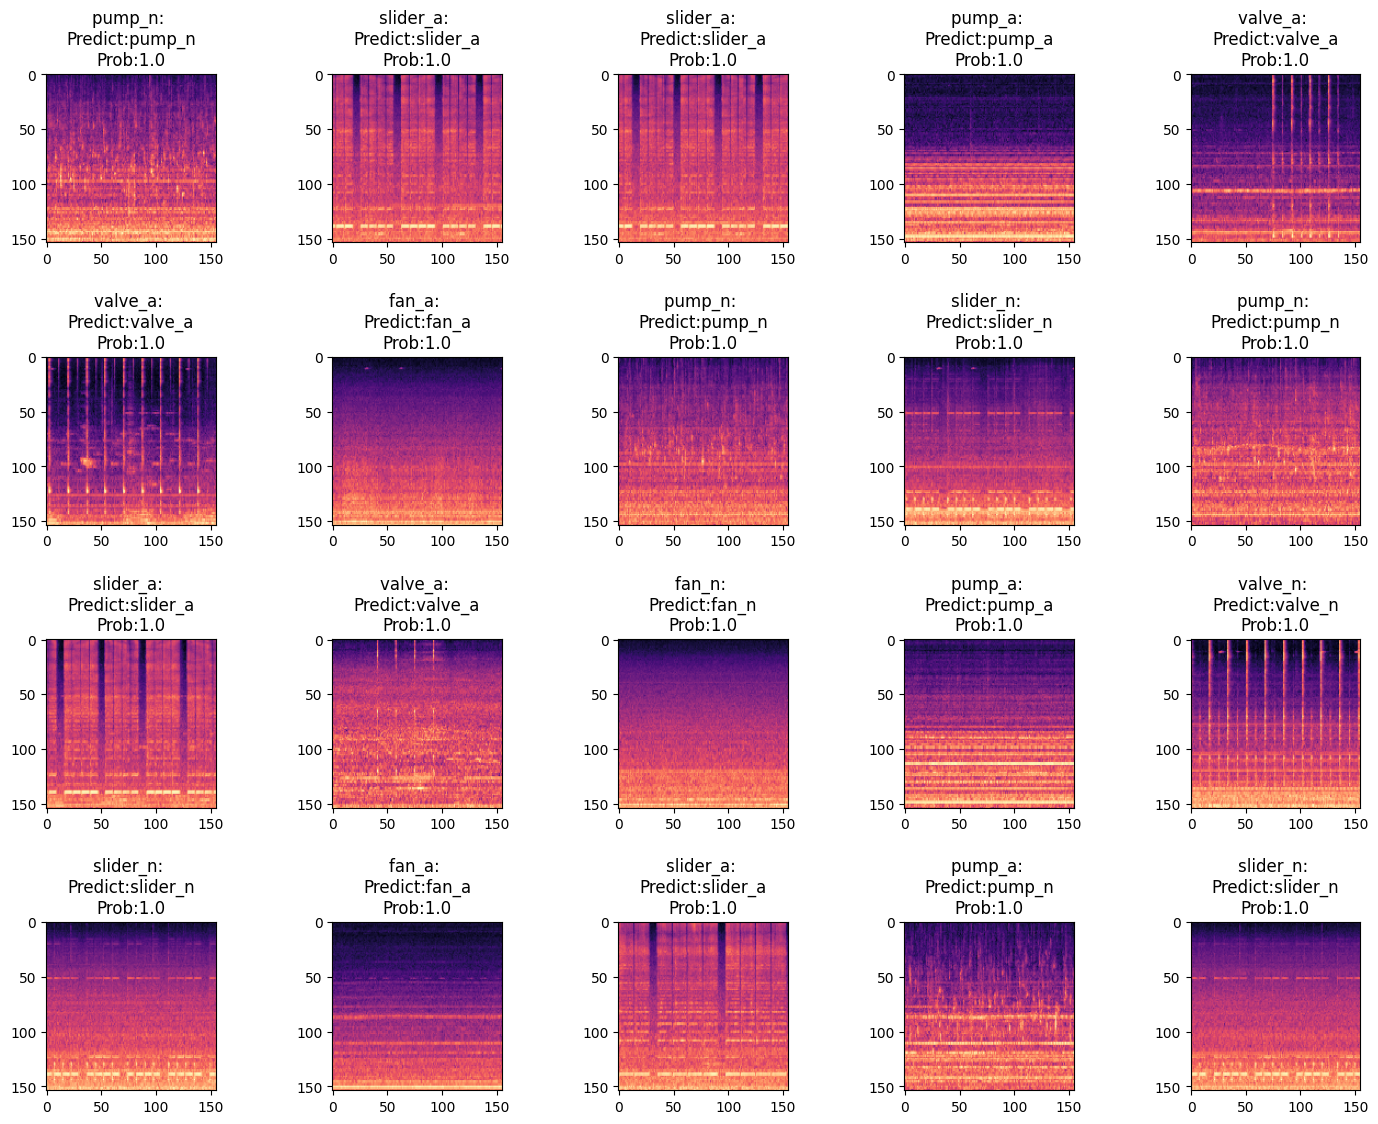

In [6]:
import torch
import pandas as pd
import os
from PIL import Image
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import timm

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform image data based on ImageNet's mean and std
transforms = {
    "train": T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ]),
    "test": T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ])
}


## Making Pridcition return class & prob
from typing import List, Tuple

from PIL import Image
import torch
import torchvision.transforms as T

def pred_class(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: T = None,
                        device: torch.device = None):


    # 2. Open image and convert to RGB
    img = Image.open(image_path).convert("RGB")

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = T.Compose([
            T.Resize(image_size),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Add error handling for out-of-range index
    if target_image_pred_label >= len(class_names) or target_image_pred_label < 0:
        classname = f"Error: Index {target_image_pred_label.item()} out of range"
    else:
        classname =  class_names[target_image_pred_label]

    prob = target_image_pred_probs.max().cpu().numpy()

    return classname , prob


def sample_picture(df, class_names, random_state=None):
    # Sample 20 random rows from the DataFrame
    sample_df = df.sample(20, random_state=random_state).copy()
    sample_df = sample_df.reset_index(drop=True)
    # Define the grid layout for displaying the images
    num_rows = 4
    num_cols = 5
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 12))
    fig.tight_layout(pad=5.0)

    # Iterate over the sampled rows and display the images in the grid
    for i, row in sample_df.iterrows():
        img = Image.open(row['path'])

        # Prediction
        pred_name , prob = pred_class(model=loaded_model,
                                      image_path=row['path'],
                                      class_names=class_names,
                                      transform=transforms["test"],
                                      device=device)

        row_idx = i // num_cols
        col_idx = i % num_cols
        axs[row_idx, col_idx].imshow(img)
        axs[row_idx, col_idx].axis('on')
        axs[row_idx, col_idx].set_title(row['subfolder_name'] + ': \nPredict:' + pred_name + '\nProb:'+ str(prob.round(decimals=2)) )

        # prediction


    plt.show()

# create an empty list to store image paths
image_paths = []

# loop through each subfolder in the "Image" directory
for root, dirs, files in os.walk('test'):
    for subfolder_name in dirs:
        # get the path to the subfolder
        subfolder_path = os.path.join(root, subfolder_name)
        # loop through each file in the subfolder
        for filename in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, filename)
            image_paths.append((image_path, subfolder_name))

# create a DataFrame from the list of image paths
df = pd.DataFrame(image_paths, columns=['path', 'subfolder_name'])

# Use ImageFolder to create dataset(s) - This is needed to get class names
dataset = datasets.ImageFolder(root='data' , # target folder of images
                                  transform=None, # transforms not needed for just getting class names
                                  target_transform=None)
classname = dataset.classes

# Instantiate the model architecture
num_classes = 8
model = timm.create_model("mobilenetv3_large_100", pretrained=False, num_classes=num_classes)

##Load some model state dict
loaded_model_state_dict = torch.load('mobilenetv3_large_100_checkpoint_fold0.pt', weights_only=False)

# Load the state dict into the model
model.load_state_dict(loaded_model_state_dict)

# Assign the loaded model to loaded_model variable for sample_picture function
loaded_model = model

# Set the model to evaluation mode and move to device after loading
loaded_model.eval()
loaded_model.to(device)
sample_picture(df, classname)

## Outsite data testing

In [139]:
# Find the model with the highest average validation accuracy across folds
best_model_name = max(all_eval_scores, key=lambda k: np.mean(all_eval_scores[k]))
best_fold = np.argmax(all_eval_scores[best_model_name])

print(f"The best performing model is {best_model_name} from fold {best_fold+1}")

# Load the best performing model checkpoint
loaded_model = torch.load(f"{best_model_name}_checkpoint_fold{best_fold}.pt")

The best performing model is densenet121 from fold 1


In [1]:
# Visualize predictions on sample test images
